In [99]:
import dowhy
import numpy as np
import graphviz
from scipy import stats
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### Causal graph plotting

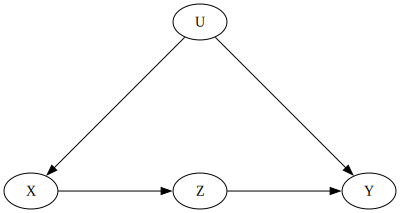

In [98]:
g_1 = graphviz.Digraph(format='png',engine = 'neato')

# Specify positions for each node (x,y)
g_1.attr(width='2', height='2', nodesep='0.5', ranksep='0.5', splines='true', overlap='false')
positions = {
    'U': '0,0!',
    'X': '-1,-1!',
    'Z': '0,-1!',
    'Y': '1,-1!'
}

for n, pos in positions.items():
    g_1.node(n, pos=pos)


g_1.edges(['UX', 'XZ', 'UY', 'ZY'])
g_1.render(filename='g_1_graph', format='png', cleanup=True)
g_1

### Defining Causal graph in string format for input to dowhy

In [26]:
gml_graph = """
graph [
    directed 1
    node [
        id "X"
        label "X"
        shape "ellipse"
    ]
    node [
        id "Z"
        label "Z"
        shape "ellipse"
    ]
    node [
        id "Y"
        label "Y"
        shape "ellipse"
    ]
    node [
        id "U"
        label "U"
        shape "ellipse"
    ]
    edge [
        source "U"
        target "X"
    ]
    edge [
        source "U"
        target "Y"
    ]
    edge [
        source "Z"
        target "Y"
    ]
    edge [
        source "X"
        target "Z"
    ]
]

"""

### Genrating data

In [92]:
class GPSMemorySCM:
    def __init__(self,random_seed = None):
      self.random_seed = random_seed
      self.u_x = stats.truncnorm(0, np.inf, scale=5)
      self.u_y = stats.norm(scale=2)
      self.u_z = stats.norm(scale=2)
      self.u = stats.truncnorm(0, np.inf, scale=4)

    def sample(self, sample_size=100, treatment_value=None):
      """Samples from the SCM"""
      if self.random_seed:
          np.random.seed(self.random_seed)
      u_x = self.u_x.rvs(sample_size)
      u_y = self.u_y.rvs(sample_size)
      u_z = self.u_z.rvs(sample_size)
      u = self.u.rvs(sample_size)
      if treatment_value:
          gps = np.array([treatment_value]*sample_size)
      else:
          gps = u_x + 0.7*u
      hippocampus = -0.6*gps + 0.25*u_z
      memory = 0.7*hippocampus + 0.25*u + 0.2*u_y
      return gps, hippocampus, memory,u

    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [93]:
dataobj = GPSMemorySCM(random_seed=42)
gps, hippocampus, memory, u = dataobj.sample(sample_size=1000)

In [94]:
df = pd.DataFrame(data={'X': gps, 'Z': hippocampus, 'Y': memory, 'U': u})
df.head()

,X,Z,Y,U
0,3.438217,-2.766089,-1.508903,1.425117
1,13.405330,-8.084751,-4.916759,5.106816
2,6.717165,-4.782659,-2.774770,1.684049
3,5.272706,-2.783595,-1.319794,1.537953
4,1.811850,-1.045890,-0.212552,1.182618


### Step 1: Create a causal model from the data and given graph.

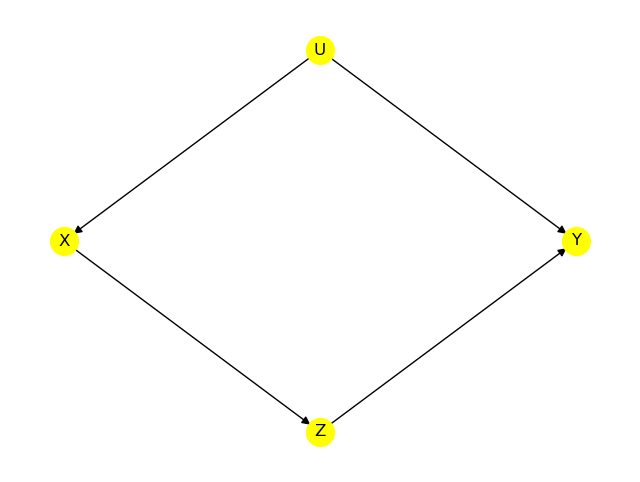

In [95]:
model = dowhy.CausalModel(
    data=df,
    graph=gml_graph,
    treatment='X',
    outcome='Y'
)
model.view_model()

### Step 2: Identify causal effect and return target estimands

Here dowhy will identify that there are backdoor and frontdoor paths possible

In [96]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|U])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,U,U) = P(Y|X,U)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



### Step 3: Estimate the target estimand using a statistical method.

In [101]:
estimated_effect = model.estimate_effect(
    identified_estimand,
    method_name="frontdoor.two_stage_regression"
)
print(estimated_effect)

two_stage_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)

## Re

### Step 4: Refute the obtained estimate using multiple robustness checks.

In [103]:
refute_results = model.refute_estimate(estimand = identified_estimand, 
                                       estimate = estimated_effect,
                                       method_name="data_subset_refuter",
                                       subset_fraction=0.4)
print(refute_results)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'first_stage_model': None, 'second_stage_model': None}
{'control_value': 0, 'treatment_value': 1, '